# Eye Disease Classification Using CNN and Transfer Learning (MobileNet)

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
import cv2
from tqdm import tqdm

In [11]:
data_path = '/kaggle/input/eye-diseases-classification/dataset/'

In [12]:
os.listdir(data_path)

['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']

## Show sample image for each class

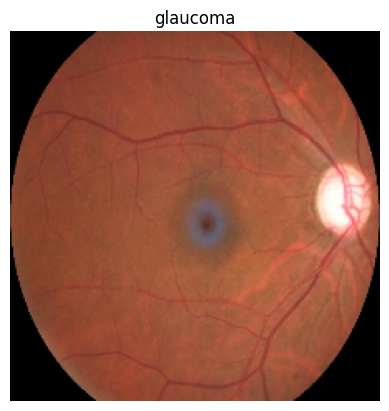

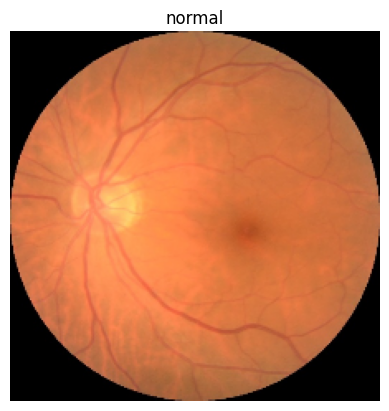

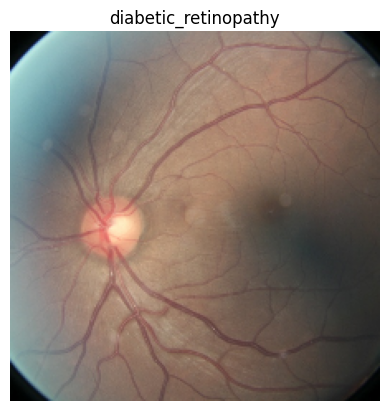

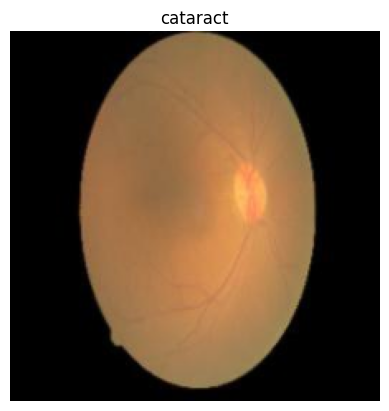

In [13]:
for i in os.listdir(data_path):
  for j in os.listdir(data_path+i):
    im = cv2.imread(data_path+i+"/"+j)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (224,224))
    plt.imshow(im)
    plt.axis("off")
    plt.title(i)
    plt.show()
    break

# Load The Data & Preprocssing

In [85]:
X = list()
y = list()
image_class = {"glaucoma":0, "normal":1,"diabetic_retinopathy":2,"cataract":3}
for i in os.listdir(data_path):
  class_dir = data_path+i+'/'
  for j in tqdm(os.listdir(class_dir)):
    origin_image = cv2.imread(class_dir+j)
    RGB_image = cv2.cvtColor(origin_image,cv2.COLOR_BGR2RGB)
    resize_image = cv2.resize(RGB_image, (224,224))
    X.append(resize_image)
    y.append(image_class[i])

100%|██████████| 1038/1038 [00:11<00:00, 88.02it/s] 


In [86]:
X = np.array(X)
y = np.array(y)

In [87]:
X.shape, y.shape

((4217, 224, 224, 3), (4217,))

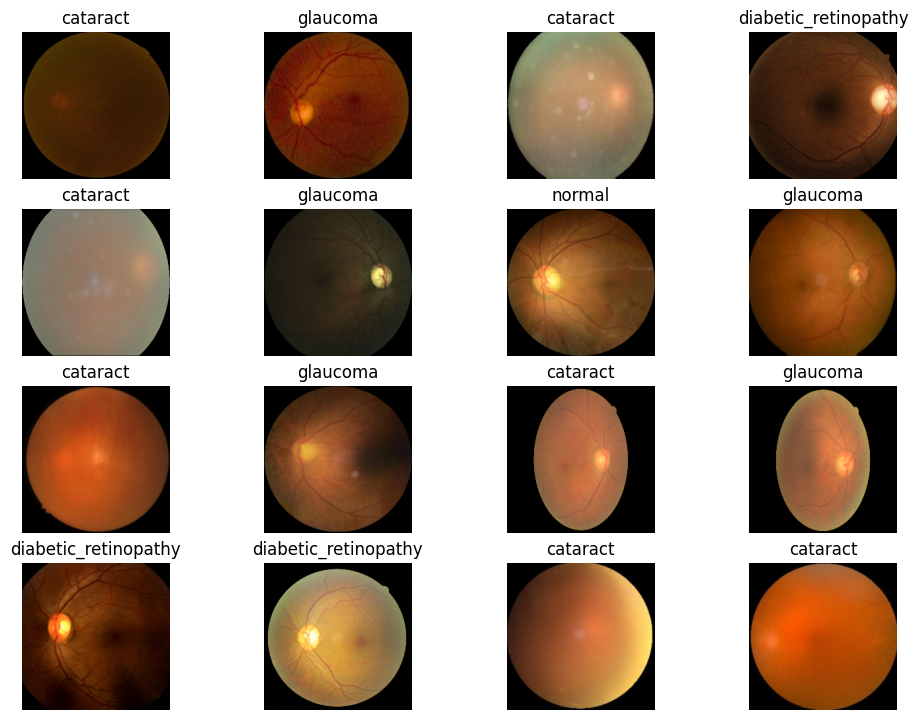

In [88]:
plt.figure(figsize=(12,18))
for n,i in enumerate(list(np.random.randint(1,len(X),16))):
  plt.subplot(8,4,n+1)
  plt.imshow(X[i])
  plt.axis("off")
  image_class = {0:"glaucoma",1:"normal",2:"diabetic_retinopathy",3:"cataract"}
  plt.title(image_class[y[i]])
plt.show()

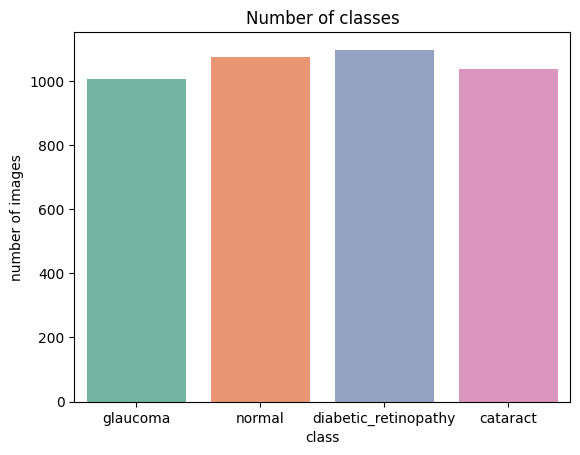

In [11]:
sns.countplot(x=y,palette="Set2")
plt.title("Number of classes")
plt.xticks(np.arange(4),os.listdir(data_path))
plt.xlabel("class")
plt.ylabel("number of images")
plt.show()

In [12]:
pd.Series(y).value_counts()

2    1098
1    1074
3    1038
0    1007
Name: count, dtype: int64

In [89]:
X = X/255.0

## Split the data into train set & test set ans shuffle

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42, stratify=y, shuffle=True)

In [110]:
X_train.shape, X_test.shape

((3162, 224, 224, 3), (1055, 224, 224, 3))

# Build CNN Model from scratch

In [116]:
model = keras.models.Sequential([
  keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu',padding='same', name='Conv1', input_shape=(224,224,3)),
              keras.layers.MaxPool2D(pool_size=2, strides=2, name='Pool1'),
  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', name='Conv2', padding='same'),
              keras.layers.MaxPool2D(pool_size=2, strides=2, name='Pool2'),
  keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', name='Conv3', padding='same'),
              keras.layers.MaxPool2D(pool_size=2, strides=2, name='Pool3'),

  keras.layers.Flatten(name='Flatten1'),
  keras.layers.Dense(units=256, activation='relu', name='Dense1'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(units=128, activation='relu', name='Dense2'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(units=64, activation='relu', name='Dense3'),
  keras.layers.Dense(units=32, activation='relu', name='Dense4'),
  keras.layers.Dense(units=4, activation='softmax', name='Output')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [117]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten1 (Flatten)              │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense3 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense4 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,794,660 (197.58 MB)

 Trainable params: 51,794,660 (197.58 MB)

 Non-trainable params: 0 (0.00 B)

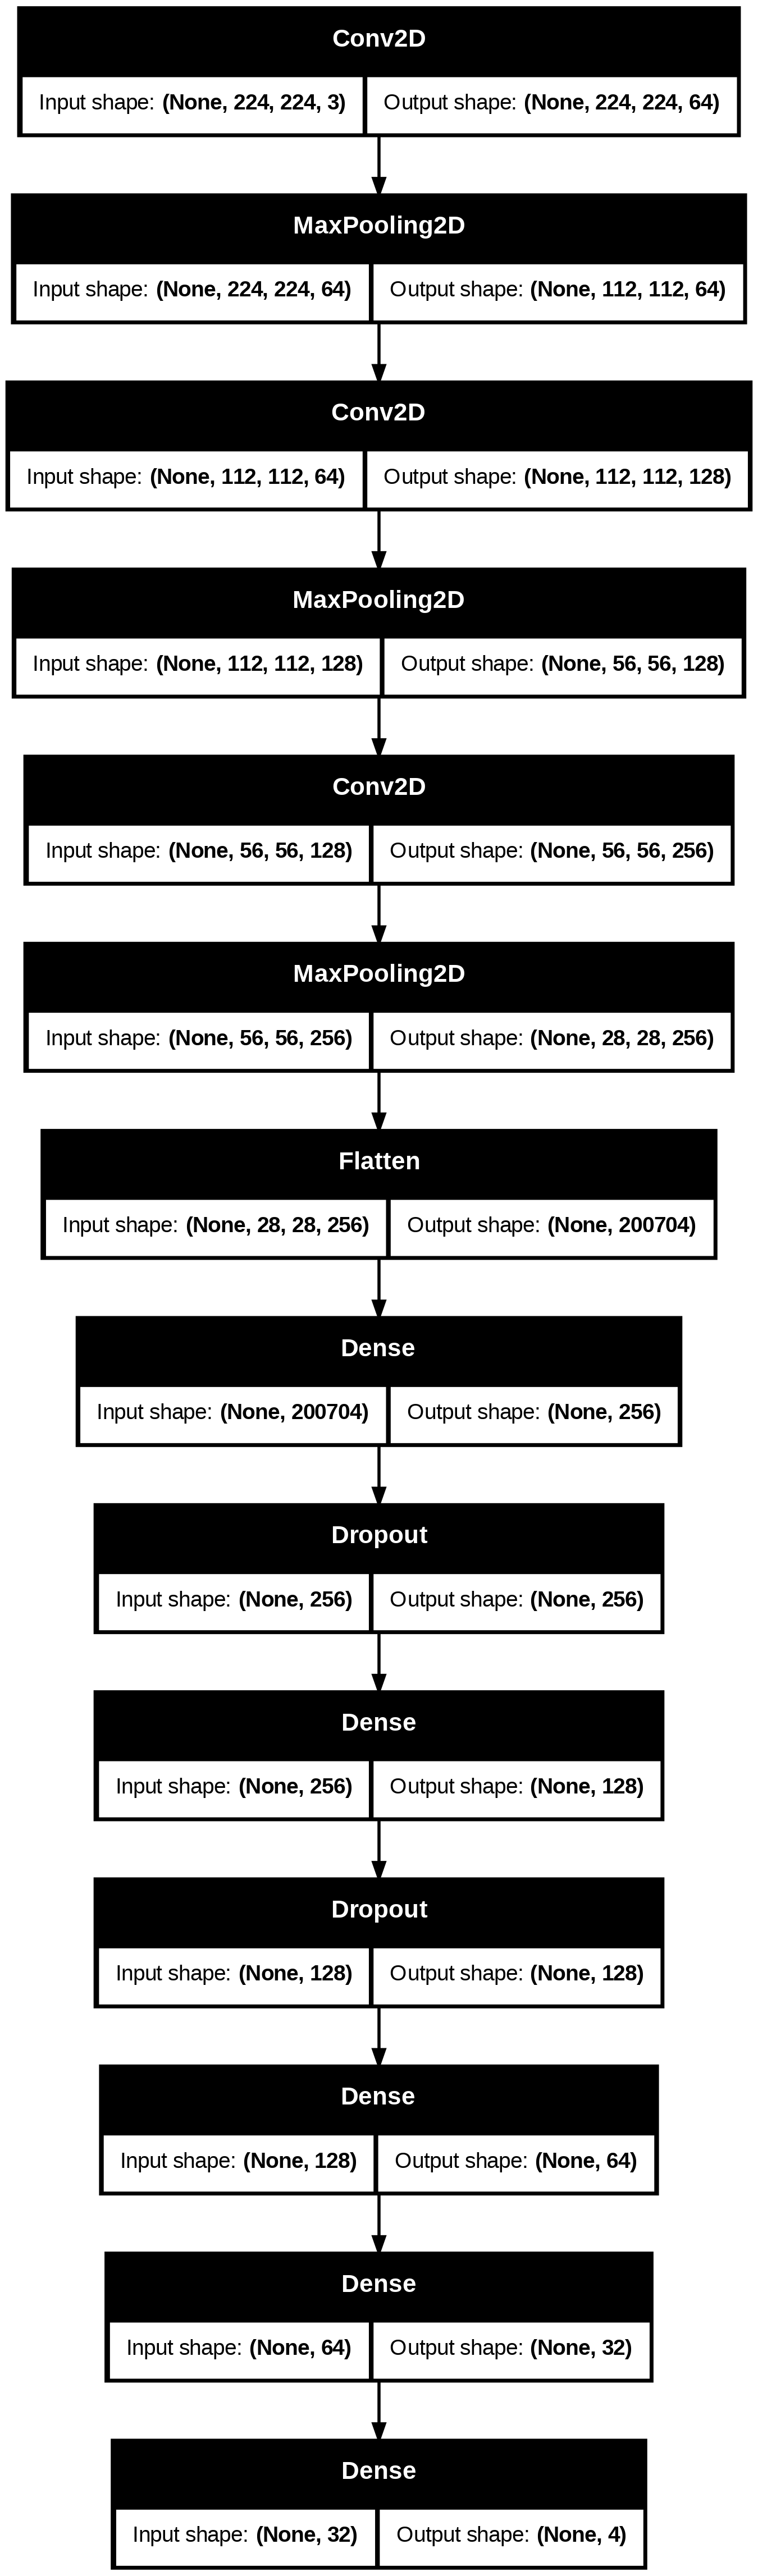

In [118]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Model Compilation

In [119]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [120]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50


2025-12-24 01:21:53.225683: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-24 01:21:53.392986: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


159/159 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - accuracy: 0.4186 - loss: 1.2345 - val_accuracy: 0.5245 - val_loss: 0.9008
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.5753 - loss: 0.8397 - val_accuracy: 0.6288 - val_loss: 0.7500
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.6656 - loss: 0.7197 - val_accuracy: 0.7156 - val_loss: 0.6471
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.7218 - loss: 0.6277 - val_accuracy: 0.6714 - val_loss: 0.6997
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.7375 - loss: 0.5852 - val_accuracy: 0.7172 - val_loss: 0.6295
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.7307 - loss: 0.5998 - val_accuracy: 0.7109 - val_loss: 0.6816
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7525 - loss: 0.5632 - val_accuracy: 0.7235 - val_loss: 0.6349
Epoch 8/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7568 - loss: 0.5540 - val_accura

In [121]:
history.history

{'accuracy': [0.5199683904647827,
  0.6061684489250183,
  0.7018584609031677,
  0.7224199175834656,
  0.7386318445205688,
  0.7334914803504944,
  0.7587979435920715,
  0.7655199766159058,
  0.7730328440666199,
  0.7690786719322205,
  0.7848952412605286,
  0.7928034663200378,
  0.7912217974662781,
  0.817714512348175,
  0.790431022644043,
  0.8173190951347351,
  0.8228548765182495,
  0.8129695653915405,
  0.8394622206687927,
  0.8529062867164612,
  0.8651641011238098,
  0.8600237369537354,
  0.8782127499580383,
  0.8960063457489014,
  0.8861209750175476,
  0.9078687429428101,
  0.9134045243263245,
  0.909450352191925,
  0.9331751465797424,
  0.9509687423706055,
  0.9525504112243652,
  0.9434559345245361,
  0.9505733251571655,
  0.972321093082428,
  0.9652036428451538,
  0.9383155107498169,
  0.9576907753944397,
  0.9707394242286682,
  0.9766706228256226,
  0.9837880730628967,
  0.9877421855926514,
  0.9782522916793823,
  0.9794384837150574,
  0.9837880730628967,
  0.9794384837150574,
  

In [123]:
model_evaluate = model.evaluate(X_test, y_test)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.7992 - loss: 1.4409
Loss     :  1.6572110652923584
Accuracy :  0.7791469097137451


In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

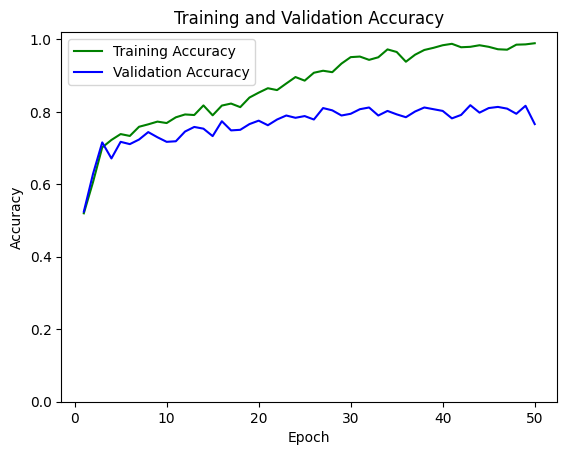

In [125]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

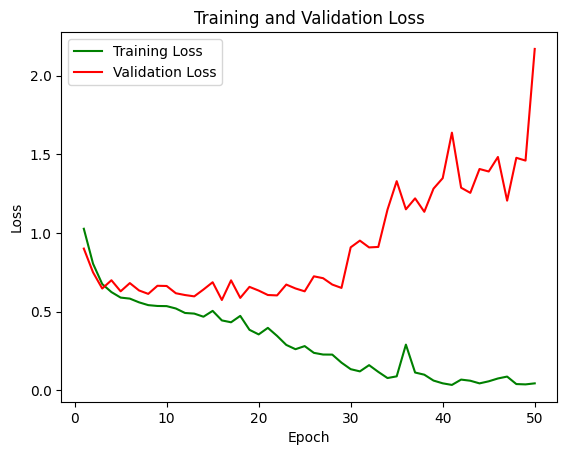

In [127]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [128]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_test, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
              precision    recall  f1-score   support

           0       0.77      0.54      0.64       252
           1       0.78      0.69      0.73       269
           2       1.00      0.99      0.99       275
           3       0.62      0.88      0.73       259

    accuracy                           0.78      1055
   macro avg       0.79      0.78      0.77      1055
weighted avg       0.80      0.78      0.78      1055



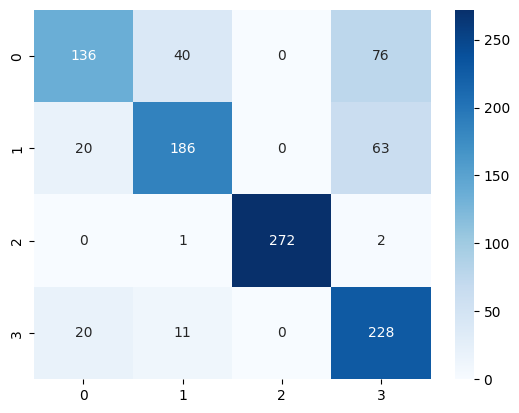

In [129]:
sns.heatmap(confusion_matrix(y_test, y_pred), fmt="g", annot=True, cmap='Blues')
plt.show()

# Transfer Learning

## TL Using MobileNet

In [130]:
from tensorflow.keras.applications import MobileNet

In [137]:
base_model = MobileNet(
    weights='imagenet', 
    include_top=False,   
    input_shape=(224, 224, 3) 
)

In [138]:
for layer in base_model.layers:
    layer.trainable = False

In [139]:
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Flatten()(x)
x = keras.layers.Dense(300, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
output = keras.layers.Dense(4, activation='softmax')(x) 

model = keras.models.Model(inputs=base_model.input, outputs=output)

In [140]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [141]:
history = model.fit(X_train, y_train,epochs=50,batch_size=16,validation_split=0.2)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.6948 - loss: 0.7771 - val_accuracy: 0.8167 - val_loss: 0.4416
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8512 - loss: 0.3857 - val_accuracy: 0.8468 - val_loss: 0.3855
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8767 - loss: 0.3240 - val_accuracy: 0.8357 - val_loss: 0.4132
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8538 - loss: 0.3498 - val_accuracy: 0.8278 - val_loss: 0.4312
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8808 - loss: 0.2805 - val_accuracy: 0.8641 - val_loss: 0.3177
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9110 - loss: 0.2251 - val_accuracy: 0.8863 - val_loss: 0.3130
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9026 - loss: 0.2232 - val_accuracy: 0.8831 - val_loss: 0.2895
Epoch 8/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9183 - loss: 0.2002 - val_acc

In [142]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9015 - loss: 0.4574
Test Accuracy: 90.62%
Test Loss: 0.4577


In [144]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_test, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       252
           1       0.84      0.86      0.85       269
           2       0.99      0.98      0.98       275
           3       0.95      0.95      0.95       259

    accuracy                           0.91      1055
   macro avg       0.91      0.91      0.91      1055
weighted avg       0.91      0.91      0.91      1055



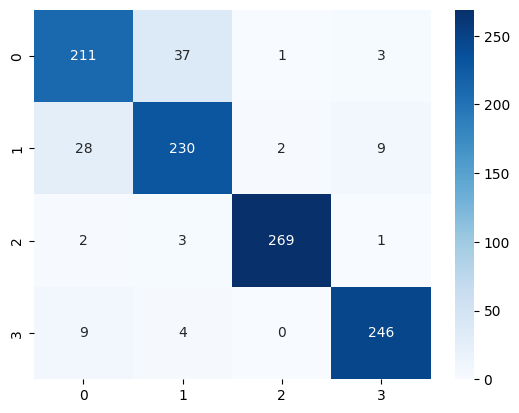

In [145]:
sns.heatmap(confusion_matrix(y_test, y_pred), fmt="g", annot=True, cmap='Blues')
plt.show()

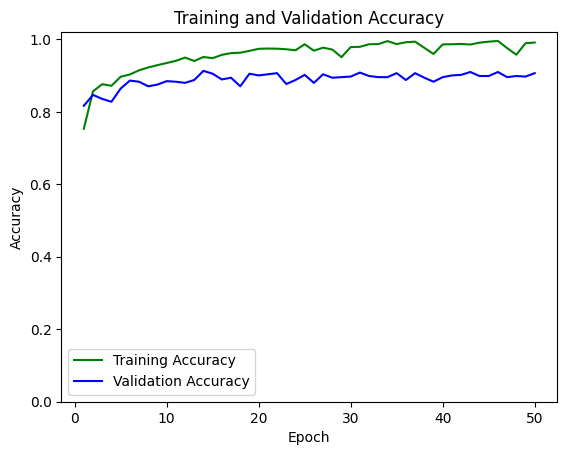

In [146]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

## Save the best model after TL

### with **Recall** = 91%

In [143]:
model.save("BestModel.h5")